In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [2]:
%run ../graph_utils.py
G = get_graph('rabbi_quotation_data')

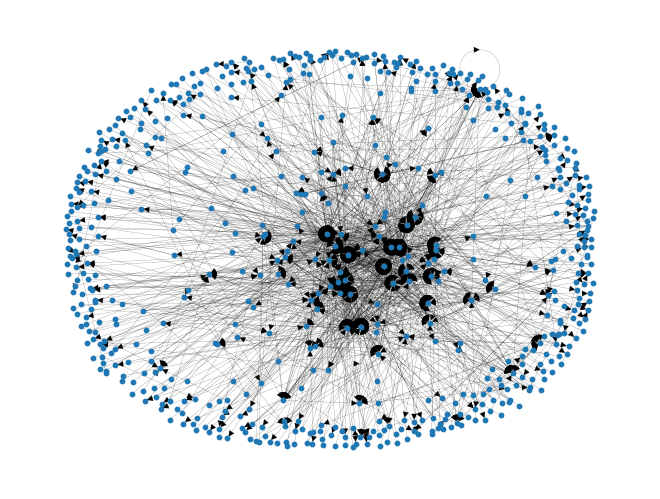

In [4]:
layout = nx.spring_layout(G)
nx.draw(G, layout, node_size=10, width=0.1)

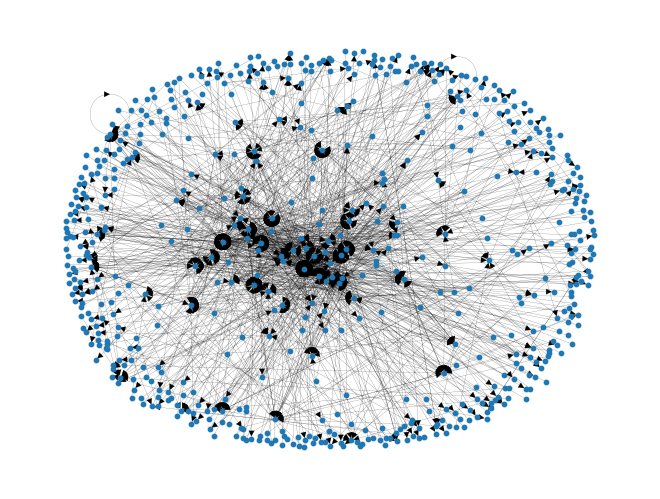

In [5]:
components = get_connected_component_subgraphs(G)
giant = components[0]
layout = nx.spring_layout(giant)
nx.draw(giant, layout, node_size=10, width=0.1)

In [6]:
pd.DataFrame({'in_degree': pd.Series(G.in_degree()), 'out_degree': pd.Series(G.out_degree())})


,in_degree,out_degree
0,"(רב יהודה בר יחזקאל, 20)","(רב יהודה בר יחזקאל, 16)"
1,"(רב, 137)","(רב, 9)"
2,"(שמואל, 52)","(שמואל, 16)"
3,"(רבה בר בר חנה, 3)","(רבה בר בר חנה, 9)"
4,"(רבי יוחנן, 85)","(רבי יוחנן, 34)"
...,...,...
625,"(רב סימון, 0)","(רב סימון, 1)"
626,"(רבי יהושע בן חנניא, 1)","(רבי יהושע בן חנניא, 0)"
627,"(רב עולא בר אבא, 0)","(רב עולא בר אבא, 1)"
628,"(רב עמרם בריה דרבי שמעון בר אבא, 0)","(רב עמרם בריה דרבי שמעון בר אבא, 2)"


In [7]:
degrees = pd.merge(
    pd.DataFrame(G.in_degree(), columns=['who', 'in_degree']),
    pd.DataFrame(G.out_degree(), columns=['who', 'out_degree']),
    on='who',
    how='outer',
).fillna(0)
degrees['total_degree'] = degrees['in_degree'] + degrees['out_degree']
degrees.sort_values('total_degree', ascending=False)

,who,in_degree,out_degree,total_degree
78,רב,137,9,146
490,רבי יוחנן,85,34,119
623,שמואל,52,16,68
124,רב הונא,38,19,57
396,רבי אלעזר בן פדת,32,20,52
...,...,...,...,...
245,רב מנשיא בר ירמיה מגיפתי,0,1,1
244,רב מנשיא בר זביד,0,1,1
243,רב מנשיא,0,1,1
241,רב מנחם איש כפר,1,0,1


In [8]:
print(G)

DiGraph named 'Rabbi quotation network' with 630 nodes and 1217 edges


## PageRank

We will now compute PagRank - a measure of authority in a network. The PageRank algorithm was developed by Larry Page and Sergey Brin in 1996 as part of their research project at Stanford University. The algorithm assigns a numerical weight to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of measuring its relative importance within the set. The algorithm may be applied to any collection of entities with reciprocal quotations and references.

This is an iterative algorithm. We start by assigning the same rank to each node.
Then, we iterate over the nodes, and for each node, we compute the rank as the sum of the ranks of the nodes that point to it, divided by the number of nodes that the pointing node points to. We then multiply this sum by a damping factor, usually set to 0.85, and add a term that accounts for the probability of jumping to any node in the network.

The dampling factor, is sometimes called the teleportation factor, and it accounts for the probability of jumping to any node in the network. The damping factor is usually set to 0.85, which means that there is a 15% probability of jumping to any node in the network. 


In [9]:
import networkx as nx
import pandas as pd

# Initialize PageRank
n_nodes = len(G.nodes)
page_rank = {node: 1.0 / n_nodes for node in G.nodes}
d = 0.85
tol = 1e-6

# Store the initial PageRank for comparison in iterations
accumulated_page_rank = [pd.Series(page_rank, name='iteration0')]

# Iterate until convergence within tolerance
iteration = 0
while iteration < 100:
    new_page_rank = {}
    for node in G.nodes:
        local_rank = 0
        # Sum the ranks of the predecessors (incoming links)
        for neighbor in G.predecessors(node):
            local_rank += page_rank[neighbor] / len(list(G.successors(neighbor)))
        new_page_rank[node] = (1 - d) / n_nodes + d * local_rank

    # Normalize the new PageRank values to ensure they sum to 1
    total_rank = sum(new_page_rank.values())
    new_page_rank = {k: v / total_rank for k, v in new_page_rank.items()}

    # Check for convergence: difference between old and new PageRank vectors
    error = sum(abs(new_page_rank[node] - page_rank[node]) for node in G.nodes)
    iteration += 1
    accumulated_page_rank.append(pd.Series(new_page_rank, name=f'iteration{iteration}'))
    
    if error < tol:
        print(f'Converged after {iteration} iterations')
        break

    # Update the PageRank for the next iteration
    page_rank = new_page_rank

# At this point, 'new_page_rank' holds


In [10]:
pr = pd.Series(new_page_rank, name='pagerank').reset_index().rename(columns={'index': 'who'})
pr = pr.merge(degrees, on='who')

Text(0, 0.5, 'In Degree')

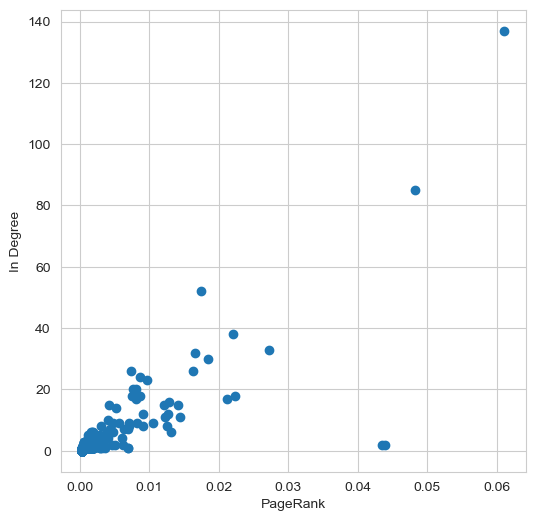

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pr['pagerank'], pr['in_degree'], 'o')
ax.set_xlabel('PageRank')
ax.set_ylabel('In Degree')


0, רבי יצחק מגדלאה                         , PR:0.04, Deg:2
1, רבי שבתאי                               , PR:0.04, Deg:2


Text(0, 0.5, 'In Degree')

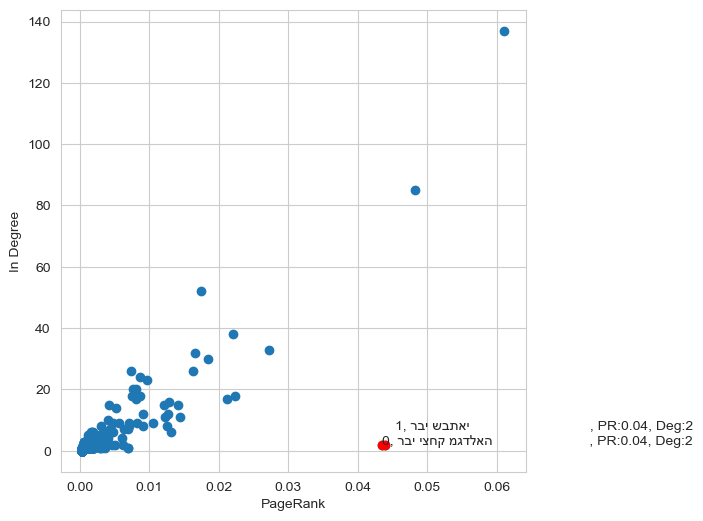

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pr['pagerank'], pr['in_degree'], 'o')
sel = (pr['pagerank'] > 0.04) & (pr['in_degree'] < 20) 
ax.plot(pr.loc[sel, 'pagerank'], pr.loc[sel, 'in_degree'], 'o', color='red')
# annotate
for i, (_, row ) in enumerate(pr.loc[sel].iterrows()):
    lbl = f'{i}, {row.who:40s}, PR:{row.pagerank:.2f}, Deg:{row.in_degree}'
    print(lbl)
    ax.text(row.pagerank + i / 700, row.in_degree + i * 5, lbl)
ax.set_xlabel('PageRank')
ax.set_ylabel('In Degree')


Of course, `networkx` has a built-in implementation of the PageRank algorithm. The actual implementation is more efficient than the one we have implemented above. Additionally, each implementation can have different normalization heuristics, different ways of handling dangling nodes, convergence criteria, and other details that can affect the results.

In [13]:
nx_pagerank = nx.pagerank(G)
if 'nx-pagerank' not in pr.columns:
    pr = pr.merge(pd.Series(nx_pagerank, name='nx-pagerank').reset_index().rename(columns={'index': 'who'}), on='who')
pr

,who,pagerank,in_degree,out_degree,total_degree,nx-pagerank
0,רב יהודה בר יחזקאל,0.007662,20,16,36,0.008242
1,רב,0.061115,137,9,146,0.079023
2,שמואל,0.017466,52,16,68,0.023108
3,רבה בר בר חנה,0.001230,3,9,12,0.000551
4,רבי יוחנן,0.048317,85,34,119,0.070332
...,...,...,...,...,...,...
625,רב סימון,0.000273,0,1,1,0.000444
626,רבי יהושע בן חנניא,0.000759,1,0,1,0.000958
627,רב עולא בר אבא,0.000273,0,1,1,0.000444
628,רב עמרם בריה דרבי שמעון בר אבא,0.000273,0,2,2,0.000444


Text(0.5, 0, 'PageRank')

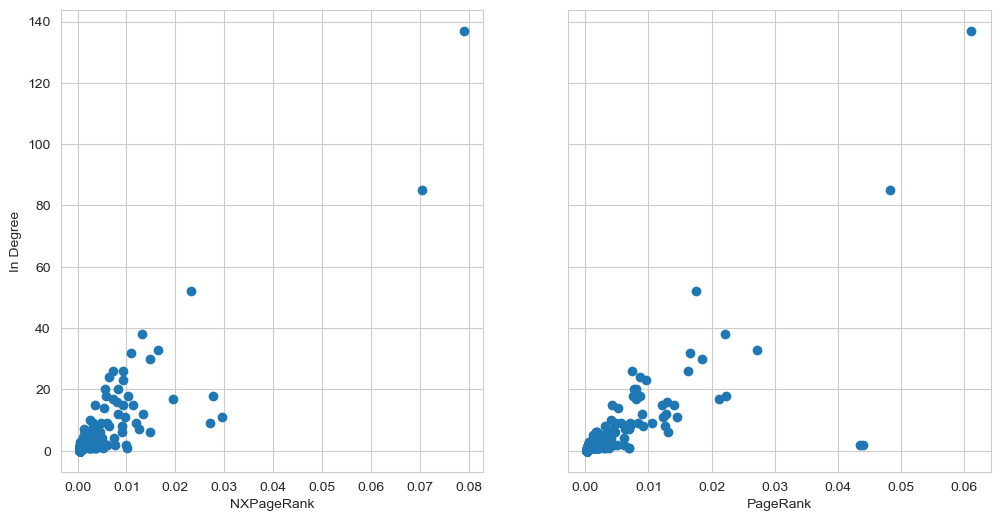

In [14]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2, sharey=True)
ax = axes[0]
ax.plot(pr['nx-pagerank'], pr['in_degree'], 'o')
ax.set_ylabel('In Degree')
ax.set_xlabel('NXPageRank')
ax = axes[1]
ax.plot(pr['pagerank'], pr['in_degree'], 'o')
ax.set_xlabel('PageRank')
# ax.set_xlabel('PageRank')
# ax.set_ylabel('PageRank (nx)')
# diagonal 
# ax.plot([0, 0.1], [0, 0.1], 'r-')

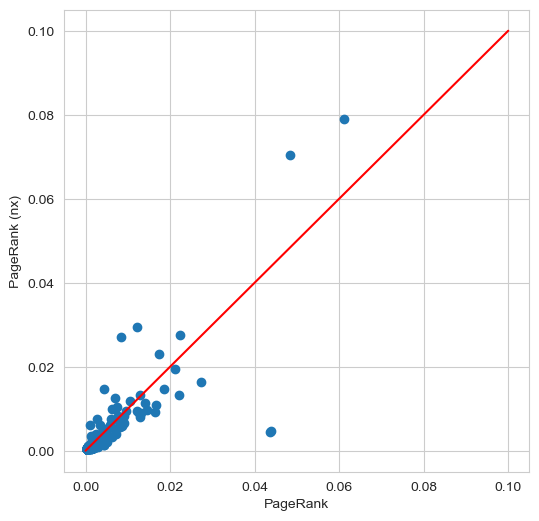

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pr['pagerank'], pr['nx-pagerank'], 'o')
ax.set_xlabel('PageRank')
ax.set_ylabel('PageRank (nx)')
ax.plot([0, 0.1], [0, 0.1], 'r-')

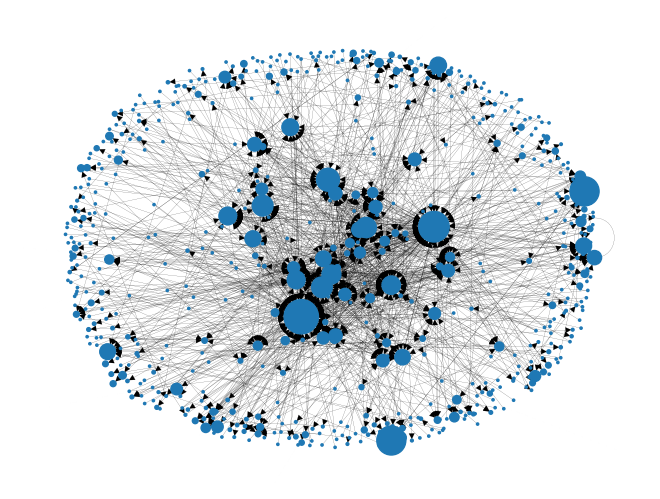

In [17]:
# plot graph and size the nodes according to the PageRank
layout = nx.spring_layout(G)
nx.draw(G, layout, node_size=10_000 * pr['pagerank'], width=0.1)

In [18]:
print(G)

DiGraph named 'Rabbi quotation network' with 630 nodes and 1217 edges
